In [ ]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
from PIL import Image
from io import BytesIO
import cv2

### Usefull functions

In [2]:

def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""


def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


### preprocess data

In [3]:
def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id



In [ ]:
with open('TEST_images.json', 'r') as j:
    img = json.load(j)
with open('TEST_objects.json', 'r') as j:
    obj = json.load(j)

In [ ]:
# path_tfrecords_train = "/home/alex/work/notebooks/tensorflow/test.tfrecords"
path_tfrecords_train =  "/home/alex/projects/tensorflow/test.tfrecords"
def wrap_float(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value)) 
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value)) 
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [ ]:
def print_progress(count, total):
    pct_complete = float(count) / total
    
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def resize(image, bbox, size = (712, 1024)): # height width):
    h, w,_ = image.shape
    w_new, h_new = size[1], size[0]
    scale_w = w_new / w # readuc la noua dim
    scale_w = scale_w / w_new # normalizez la [0,1]
    
    scale_h = h_new / h
    scale_h = scale_h / h_new
    
#     print(scale_h, scale_w)
    image = tf.image.resize(image, size)
#     bbox = bbox.numpy()
    bbox = tf.stack(
            [bbox[:, 0]*scale_w , bbox[:, 1]*scale_h, bbox[:, 2]*scale_w, bbox[:, 3]*scale_h], axis=-1
        )
    return image, bbox
    
def preprocess_data(sample, labels, bboxes):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample
    class_id = tf.cast(labels, dtype=tf.int32)
    
    bbox = bboxes # (x1, y1, x2, y2 (whwh))
#     image, bbox = random_flip_horizontal(image, bbox)

    # reshape image to 
    image, bbox = resize(image, bbox) 
    
    bbox = swap_xy(bbox)
    
    bbox = tf.cast(bbox, dtype=tf.float64)
    
    bbox = convert_to_xywh(bbox)
    
    bbox = tf.reshape(bbox, (4*bbox.shape[0]))

    return image, bbox, class_id

In [307]:
def convert(image_paths, labels=[], bboxes=[], out_path="/home/alex/projects/tensorflow/test.tfrecords"):
    print("Converting: "+out_path)
    
    num_images = len(image_paths)
    
    with tf.io.TFRecordWriter(out_path) as writer:
        
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            
            img = Image.open(path)
            img = cv2.imread(path, 3).astype(np.uint8)

            w, h, _ = img.shape
            img, b, l = preprocess_data(np.array(img), label['labels'], np.array(label['boxes']))
            
            img = img.numpy().astype(np.uint8)
            img_bytes = img.tobytes()

            # create a dict with the data we want to save in the TFrecords file. 
            data = \
                {
                    'image' : wrap_bytes(img_bytes),
                    'label' : wrap_int64(l),
                    'bbox' : wrap_float(b),
                    'width' : wrap_int64([w]),
                    'height' : wrap_int64([h])
                    
                }
            feature = tf.train.Features(feature=data)
            example = tf.train.Example(features=feature)
            serialized = example.SerializeToString()
#             if(i == 10):
            writer.write(serialized)
            print_progress(i, num_images)
#                 break

In [308]:
convert(img, obj)

Converting: /home/alex/projects/tensorflow/test.tfrecords
- Progress: 99.9%

In [309]:
def parse(serialized):
    features = {
        'image' : tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.VarLenFeature(tf.int64), 
        'bbox' : tf.io.VarLenFeature(tf.float32),
        'width' :  tf.io.FixedLenFeature([], tf.int64),
        'height' :  tf.io.FixedLenFeature([], tf.int64)
    }
    
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    
    image_raw = parsed_example['image']
    print(features['image'].dtype)
    image = tf.io.decode_raw(image_raw, tf.uint8)
    image = tf.cast(image, tf.float32)
    
    label = parsed_example['label']
    width = parsed_example['width']
    height = parsed_example['height']
    image = tf.reshape(image, shape=[712, 1024,3])
    bbox = parsed_example['bbox']
    bbox =  tf.sparse.to_dense(bbox)
    l = len(bbox)
    bbox = tf.reshape(bbox, (l//4,4))
    
    
    return image, label, bbox

In [310]:
dataset = tf.data.TFRecordDataset(filenames=path_tfrecords_train)
dataset = dataset.map(parse)
# dataset =  dataset.batch(3)
# ex = next(iter(dataset))

<dtype: 'string'>


In [311]:
for i in dataset:
    print(i[0].dtype, i[1].dtype, i[1].shape, i[2].dtype, i[2].shape)
#     t = np.array(i[0])[:,:,[2, 1, 0]]
#     t = np.ascontiguousarray(t, dtype=np.uint8)
#     plt.imshow(t)
    print(i[2])
    tf.image.draw_bounding_boxes([i[0]], [i[2]],  colors=np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]]))
    break

<dtype: 'float32'> <dtype: 'int64'> (7,) <dtype: 'float32'> (7, 4)
tf.Tensor(
[[0.07847222 0.7457031  0.15694444 0.17109375]
 [0.12222222 0.7074219  0.01944445 0.03828125]
 [0.29305556 0.20742187 0.27222222 0.32578126]
 [0.13194445 0.34140626 0.20555556 0.2921875 ]
 [0.4173611  0.1046875  0.3263889  0.209375  ]
 [0.48194444 0.17265625 0.06388889 0.0375    ]
 [0.31875    0.34453124 0.04861111 0.028125  ]], shape=(7, 4), dtype=float32)


In [298]:
(720, 1280, 3)


(720, 1280, 3)

In [299]:
i[2]

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.03124605, 0.553125  , 0.34086606, 0.771875  ],
       [0.29399696, 0.5890625 , 0.31956193, 0.6390625 ],
       [0.4587489 , 0.15546875, 0.5269221 , 0.19140625],
       [0.2982578 , 0.04765625, 0.5794723 , 0.209375  ],
       [0.15765055, 0.07265625, 0.43886504, 0.37109375],
       [0.0397677 , 0.196875  , 0.22156294, 0.48828125],
       [0.30109835, 0.33046874, 0.35080796, 0.35859376]], dtype=float32)>

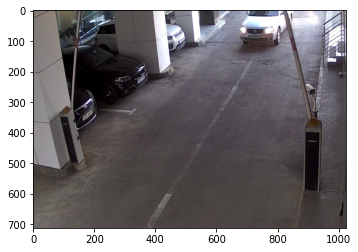

In [312]:
a = tf.image.draw_bounding_boxes([i[0]], [i[2]],  colors=np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]]))
t = np.array(a[0])[:,:,[2, 1, 0]]
t = np.ascontiguousarray(t, dtype=np.uint8)
plt.imshow(t)

In [268]:
i[2]

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.03124605, 0.8642578 , 0.34086606, 1.2060547 ],
       [0.29399696, 0.92041016, 0.31956193, 0.99853516],
       [0.4587489 , 0.24291992, 0.5269221 , 0.29907227],
       [0.2982578 , 0.07446289, 0.5794723 , 0.32714844],
       [0.15765055, 0.11352539, 0.43886504, 0.579834  ],
       [0.0397677 , 0.3076172 , 0.22156294, 0.76293945],
       [0.30109835, 0.5163574 , 0.35080796, 0.56030273]], dtype=float32)>